# Boltz Structure Prediction Analysis: Protein-Ligand Accuracy Correlation

This notebook provides a comprehensive analysis of Boltz protein structure predictions and their impact on ligand binding pose accuracy. We analyze over 1000+ protein-ligand complexes to understand the relationship between protein structure prediction quality and ligand placement accuracy.

## Research Questions:
1. How does protein structure prediction accuracy affect ligand binding pose prediction?
2. Is there a correlation between protein RMSD and ligand RMSD?
3. What factors influence the quality of ligand pose predictions?
4. Can we identify systematic patterns in prediction failures?

## Dataset:
- **Source**: PoseBench benchmark dataset
- **Method**: Boltz structure prediction
- **Size**: 1000+ protein-ligand complexes
- **Metrics**: CA RMSD, backbone RMSD, ligand RMSD, confidence scores

## 1. Import Required Libraries

Import all necessary libraries for data analysis, statistics, and visualization.

In [13]:
# Standard libraries
import sys
import os
import numpy as np
import pandas as pd
import json
import glob
import warnings
from typing import Tuple, Optional, Dict, List
from tqdm import tqdm

# Scientific computing and statistics
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.transform import Rotation

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Structural biology libraries
from Bio.PDB import PDBParser, Superimposer
from Bio.PDB.PDBExceptions import PDBConstructionWarning

# RDKit for ligand analysis
from rdkit import Chem
from rdkit.Chem import rdMolAlign

# Custom modules
sys.path.append('/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks')
from boltz_structure_analysis import (
    run_comprehensive_boltz_analysis,
    compute_protein_rmsd_comprehensive,
    compute_ligand_rmsd_comprehensive,
    analyze_protein_ligand_dependency
)

# Configure matplotlib and seaborn for better plots
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings("ignore", category=PDBConstructionWarning)

print("✅ All libraries imported successfully!")
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

✅ All libraries imported successfully!
Python version: 3.8.18 | packaged by conda-forge | (default, Oct 10 2023, 15:46:56) 
[Clang 16.0.6 ]
NumPy version: 1.24.4
Pandas version: 2.0.3


## 2. Load and Explore the Dataset

Load the Boltz prediction results and perform initial data exploration.

In [14]:
# Configuration paths
base_outdir = "/Users/aoxu/projects/DrugDiscovery/PoseBench/forks/boltz/inference/plinder_set_0"
data_dir = "/Users/aoxu/projects/DrugDiscovery/PoseBench/data/plinder_set"
output_csv = "/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/boltz_full_analysis_results.csv"

print("🔍 Data Discovery Phase")
print("=" * 50)

# Check if we have existing results or need to run analysis
if os.path.exists(output_csv):
    print(f"📊 Loading existing results from: {output_csv}")
    df_results = pd.read_csv(output_csv)
    print(f"✅ Loaded {len(df_results)} existing results")
else:
    print(f"🧬 Running comprehensive analysis on all available proteins...")
    print(f"📁 Prediction directory: {base_outdir}")
    print(f"📁 Reference directory: {data_dir}")
    
    # Check available protein directories
    protein_dirs = sorted([d for d in os.listdir(base_outdir) if os.path.isdir(os.path.join(base_outdir, d))])
    print(f"🎯 Found {len(protein_dirs)} protein directories")
    
    # Show first few directories as examples
    print(f"📝 Example directories: {protein_dirs[:3]}...")
    
    print("\n⚡ Starting comprehensive analysis - this may take several minutes...")

# Display basic dataset information
print(f"\n📈 Dataset Overview:")
print(f"Total results: {len(df_results) if 'df_results' in locals() else 'TBD'}")
if 'df_results' in locals():
    print(f"Unique proteins: {df_results['protein'].nunique()}")
    print(f"Models per protein: {df_results.groupby('protein')['model'].count().mean():.1f}")
    print(f"Date range: Analysis run on {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")

🔍 Data Discovery Phase
📊 Loading existing results from: /Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/boltz_full_analysis_results.csv
✅ Loaded 2877 existing results

📈 Dataset Overview:
Total results: 2877
Unique proteins: 959
Models per protein: 3.0
Date range: Analysis run on 2025-06-19 20:51:10


## 2.5 Affinity Prediction Analysis

Boltz also provides affinity predictions alongside structure predictions. We'll analyze:
- **affinity_pred_value**: Standardized value similar to IC50 (lower = stronger binding)
- **affinity_probability_binary**: Probability that the ligand is a binder (0-1 scale)

These metrics help us understand not just structural accuracy but also predicted binding strength.

In [15]:
def load_affinity_data(base_outdir, df_results):
    """
    Load affinity prediction data from Boltz JSON files and merge with RMSD results.
    
    Args:
        base_outdir: Base directory containing Boltz results
        df_results: DataFrame with RMSD analysis results
        
    Returns:
        DataFrame with affinity data merged
    """
    print("🧬 Loading Affinity Prediction Data...")
    
    affinity_data = []
    missing_files = 0
    
    for idx, row in tqdm(df_results.iterrows(), total=len(df_results), desc="Loading affinity data"):
        protein_name = row['protein']
        model_num = row['model']
        
        # Construct paths to affinity files
        protein_dir = f"boltz_results_{protein_name}"
        affinity_file = os.path.join(
            base_outdir, protein_dir, "predictions", protein_name,
            f"affinity_{protein_name}_model_{model_num}.json"
        )
        
        # Also check for files without model suffix (sometimes affinity is shared)
        affinity_file_alt = os.path.join(
            base_outdir, protein_dir, "predictions", protein_name,
            f"affinity_{protein_name}.json"
        )
        
        affinity_values = {
            'affinity_pred_value': np.nan,
            'affinity_probability_binary': np.nan,
            'affinity_file_found': False
        }
        
        # Try to load affinity data
        for af_file in [affinity_file, affinity_file_alt]:
            if os.path.exists(af_file):
                try:
                    with open(af_file, 'r') as f:
                        affinity_json = json.load(f)
                    
                    # Extract main affinity values
                    affinity_values.update({
                        'affinity_pred_value': affinity_json.get('affinity_pred_value', np.nan),
                        'affinity_probability_binary': affinity_json.get('affinity_probability_binary', np.nan),
                        'affinity_file_found': True
                    })
                    
                    # Also extract alternative predictions if available
                    for suffix in ['1', '2']:
                        if f'affinity_pred_value{suffix}' in affinity_json:
                            affinity_values[f'affinity_pred_value_{suffix}'] = affinity_json[f'affinity_pred_value{suffix}']
                        if f'affinity_probability_binary{suffix}' in affinity_json:
                            affinity_values[f'affinity_probability_binary_{suffix}'] = affinity_json[f'affinity_probability_binary{suffix}']
                    
                    break  # Found file, stop looking
                    
                except Exception as e:
                    print(f"Error loading {af_file}: {e}")
                    continue
        
        if not affinity_values['affinity_file_found']:
            missing_files += 1
        
        # Add protein and model info for merging
        affinity_values.update({
            'protein': protein_name,
            'model': model_num
        })
        
        affinity_data.append(affinity_values)
    
    # Convert to DataFrame
    df_affinity = pd.DataFrame(affinity_data)
    
    print(f"📊 Affinity Data Summary:")
    print(f"   • Total files processed: {len(df_results)}")
    print(f"   • Affinity files found: {len(df_results) - missing_files}")
    print(f"   • Missing files: {missing_files}")
    print(f"   • Success rate: {(len(df_results) - missing_files) / len(df_results) * 100:.1f}%")
    
    # Merge with original results
    df_merged = df_results.merge(df_affinity[['protein', 'model', 'affinity_pred_value', 
                                            'affinity_probability_binary', 'affinity_file_found']], 
                               on=['protein', 'model'], how='left')
    
    return df_merged

# Load affinity data if we have results
if 'df_results' in locals() and len(df_results) > 0:
    print("🔍 Integrating Affinity Predictions with RMSD Analysis...")
    df_with_affinity = load_affinity_data(base_outdir, df_results)
    
    # Show affinity data statistics
    print(f"\n📈 Affinity Prediction Statistics:")
    affinity_stats = df_with_affinity[['affinity_pred_value', 'affinity_probability_binary']].describe()
    display(affinity_stats.round(3))
    
    # Check for missing values
    print(f"\n📊 Missing Values in Affinity Data:")
    affinity_missing = df_with_affinity[['affinity_pred_value', 'affinity_probability_binary']].isnull().sum()
    print(f"   • Affinity pred value missing: {affinity_missing['affinity_pred_value']} ({affinity_missing['affinity_pred_value']/len(df_with_affinity)*100:.1f}%)")
    print(f"   • Affinity probability missing: {affinity_missing['affinity_probability_binary']} ({affinity_missing['affinity_probability_binary']/len(df_with_affinity)*100:.1f}%)")
    
    # Example affinity values
    valid_affinity = df_with_affinity.dropna(subset=['affinity_pred_value', 'affinity_probability_binary'])
    if len(valid_affinity) > 0:
        print(f"\n🎯 Example Affinity Values (first 5 valid entries):")
        display(valid_affinity[['protein', 'model', 'affinity_pred_value', 'affinity_probability_binary', 
                               'protein_ca_aligned_rmsd', 'ligand_rmsd', 'confidence']].head())
    
else:
    print("❌ No RMSD results available - run the main analysis first")

🔍 Integrating Affinity Predictions with RMSD Analysis...
🧬 Loading Affinity Prediction Data...


Loading affinity data: 100%|██████████| 2877/2877 [00:00<00:00, 5316.88it/s]

📊 Affinity Data Summary:
   • Total files processed: 2877
   • Affinity files found: 2877
   • Missing files: 0
   • Success rate: 100.0%

📈 Affinity Prediction Statistics:


,affinity_pred_value,affinity_probability_binary
count,2877.000,2877.000
mean,0.612,0.517
std,1.097,0.245
min,-3.330,0.062
25%,-0.106,0.305
50%,0.615,0.503
75%,1.384,0.723
max,3.102,0.996



📊 Missing Values in Affinity Data:
   • Affinity pred value missing: 0 (0.0%)
   • Affinity probability missing: 0 (0.0%)

🎯 Example Affinity Values (first 5 valid entries):


,protein,model,affinity_pred_value,affinity_probability_binary,protein_ca_aligned_rmsd,ligand_rmsd,confidence
0,1afb__1__1.A__1.D_1.F,0,2.070070,0.350401,7.288223,3.383638,0.968682
1,1afb__1__1.A__1.D_1.F,1,2.070070,0.350401,8.294978,3.389537,0.967638
2,1afb__1__1.A__1.D_1.F,2,2.070070,0.350401,7.902068,3.383763,0.966930
3,1b5d__1__1.A_1.B__1.D,0,0.346715,0.691342,0.406931,4.451248,0.978817
4,1b5d__1__1.A_1.B__1.D,1,0.346715,0.691342,0.379730,4.489508,0.978379


In [16]:
# Run the comprehensive analysis if we don't have existing results
if 'df_results' not in locals() or len(df_results) == 0:
    print("🚀 Executing comprehensive Boltz analysis...")
    
    # Modify the analysis script to process all proteins (not just first 50)
    import sys
    sys.path.append('/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks')
    
    # Load the analysis module and run with all proteins
    exec(open('/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/boltz_structure_analysis.py').read())
    
    # Read the results
    df_results = pd.read_csv(output_csv)
    print(f"✅ Analysis complete! Generated {len(df_results)} results")

else:
    print("✅ Using existing analysis results")

# Display the first few rows and basic statistics
print("\n📊 First 5 rows of results:")
display(df_results.head())

print(f"\n📋 Dataset Info:")
print(f"Shape: {df_results.shape}")
print(f"Columns: {list(df_results.columns)}")
print(f"Memory usage: {df_results.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

✅ Using existing analysis results

📊 First 5 rows of results:


,protein,model,confidence,protein_ca_aligned_rmsd,protein_backbone_aligned_rmsd,ligand_rmsd,ligand_coordinate_rmsd,binding_site_aligned_rmsd,atom_count_match
0,1afb__1__1.A__1.D_1.F,0,0.968682,7.288223,7.234416,3.383638,61.863091,NaN,True
1,1afb__1__1.A__1.D_1.F,1,0.967638,8.294978,8.238616,3.389537,53.674979,NaN,True
2,1afb__1__1.A__1.D_1.F,2,0.966930,7.902068,7.843212,3.383763,64.802147,NaN,True
3,1b5d__1__1.A_1.B__1.D,0,0.978817,0.406931,0.415178,4.451248,36.340150,NaN,True
4,1b5d__1__1.A_1.B__1.D,1,0.978379,0.379730,0.384278,4.489508,25.794543,NaN,True



📋 Dataset Info:
Shape: (2877, 9)
Columns: ['protein', 'model', 'confidence', 'protein_ca_aligned_rmsd', 'protein_backbone_aligned_rmsd', 'ligand_rmsd', 'ligand_coordinate_rmsd', 'binding_site_aligned_rmsd', 'atom_count_match']
Memory usage: 0.4 MB


## 3. Data Cleaning and Preprocessing

Clean the dataset by handling missing values, outliers, and preparing data for analysis.

In [17]:
print("🧹 Data Cleaning and Preprocessing")
print("=" * 40)

# Make a copy for cleaning
df_clean = df_results.copy()

# Check for missing values
print("📊 Missing Value Analysis:")
missing_summary = df_clean.isnull().sum()
missing_pct = (missing_summary / len(df_clean)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_summary,
    'Missing %': missing_pct
}).round(2)
print(missing_df[missing_df['Missing Count'] > 0])

# Remove rows where critical metrics are missing
initial_count = len(df_clean)
df_clean = df_clean.dropna(subset=['protein_ca_aligned_rmsd', 'ligand_rmsd'])
final_count = len(df_clean)
print(f"\n🔍 Removed {initial_count - final_count} rows with missing critical metrics")
print(f"📈 Retained {final_count} rows for analysis")

# Identify and handle outliers using IQR method
def identify_outliers(series, factor=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return (series < lower_bound) | (series > upper_bound)

print("\n🎯 Outlier Analysis:")
outlier_cols = ['protein_ca_aligned_rmsd', 'protein_backbone_aligned_rmsd', 'ligand_rmsd', 'confidence']
outlier_summary = {}

for col in outlier_cols:
    if col in df_clean.columns:
        outliers = identify_outliers(df_clean[col])
        outlier_count = outliers.sum()
        outlier_pct = (outlier_count / len(df_clean)) * 100
        outlier_summary[col] = {'count': outlier_count, 'percentage': outlier_pct}
        print(f"{col}: {outlier_count} outliers ({outlier_pct:.1f}%)")

# Create quality flags
df_clean['high_quality'] = (
    (df_clean['protein_ca_aligned_rmsd'] <= 5.0) & 
    (df_clean['ligand_rmsd'] <= 5.0) &
    (df_clean['confidence'] >= 0.8)
)

df_clean['very_high_quality'] = (
    (df_clean['protein_ca_aligned_rmsd'] <= 2.0) & 
    (df_clean['ligand_rmsd'] <= 2.0) &
    (df_clean['confidence'] >= 0.9)
)

print(f"\n✨ Quality Assessment:")
print(f"High quality predictions: {df_clean['high_quality'].sum()} ({df_clean['high_quality'].mean()*100:.1f}%)")
print(f"Very high quality predictions: {df_clean['very_high_quality'].sum()} ({df_clean['very_high_quality'].mean()*100:.1f}%)")

# Add derived columns for analysis
df_clean['protein_ligand_rmsd_ratio'] = df_clean['protein_ca_aligned_rmsd'] / df_clean['ligand_rmsd']
df_clean['combined_rmsd'] = np.sqrt(df_clean['protein_ca_aligned_rmsd']**2 + df_clean['ligand_rmsd']**2)

print(f"\n📊 Final cleaned dataset: {len(df_clean)} rows × {len(df_clean.columns)} columns")

🧹 Data Cleaning and Preprocessing
📊 Missing Value Analysis:
                           Missing Count  Missing %
ligand_rmsd                            3        0.1
ligand_coordinate_rmsd                 3        0.1
binding_site_aligned_rmsd           2877      100.0

🔍 Removed 3 rows with missing critical metrics
📈 Retained 2874 rows for analysis

🎯 Outlier Analysis:
protein_ca_aligned_rmsd: 362 outliers (12.6%)
protein_backbone_aligned_rmsd: 356 outliers (12.4%)
ligand_rmsd: 84 outliers (2.9%)
confidence: 147 outliers (5.1%)

✨ Quality Assessment:
High quality predictions: 1972 (68.6%)
Very high quality predictions: 46 (1.6%)

📊 Final cleaned dataset: 2874 rows × 13 columns


## 4. Statistical Analysis of Cases

Perform comprehensive statistical analysis to understand the relationships between protein structure accuracy and ligand binding pose accuracy.

In [18]:
print("📊 Comprehensive Statistical Analysis")
print("=" * 45)

# Descriptive statistics
print("🔢 Descriptive Statistics:")
desc_stats = df_clean[['protein_ca_aligned_rmsd', 'protein_backbone_aligned_rmsd', 
                       'ligand_rmsd', 'confidence']].describe()
display(desc_stats.round(3))

# Correlation analysis
print("\n🔗 Correlation Analysis:")
correlation_pairs = [
    ('protein_ca_aligned_rmsd', 'ligand_rmsd'),
    ('protein_backbone_aligned_rmsd', 'ligand_rmsd'),
    ('confidence', 'protein_ca_aligned_rmsd'),
    ('confidence', 'ligand_rmsd'),
    ('protein_ca_aligned_rmsd', 'protein_backbone_aligned_rmsd')
]

correlation_results = []
for var1, var2 in correlation_pairs:
    # Remove NaN values for this pair
    valid_data = df_clean[[var1, var2]].dropna()
    
    if len(valid_data) > 3:  # Need at least 4 points for correlation
        # Pearson correlation
        pearson_r, pearson_p = pearsonr(valid_data[var1], valid_data[var2])
        
        # Spearman correlation (rank-based, more robust to outliers)
        spearman_r, spearman_p = spearmanr(valid_data[var1], valid_data[var2])
        
        correlation_results.append({
            'Variable 1': var1,
            'Variable 2': var2,
            'N': len(valid_data),
            'Pearson r': pearson_r,
            'Pearson p-value': pearson_p,
            'Spearman ρ': spearman_r,
            'Spearman p-value': spearman_p,
            'Significance': '***' if min(pearson_p, spearman_p) < 0.001 else 
                          '**' if min(pearson_p, spearman_p) < 0.01 else 
                          '*' if min(pearson_p, spearman_p) < 0.05 else 'ns'
        })

corr_df = pd.DataFrame(correlation_results)
display(corr_df.round(4))

# Key finding: Protein-Ligand relationship
protein_ligand_data = df_clean[['protein_ca_aligned_rmsd', 'ligand_rmsd']].dropna()
if len(protein_ligand_data) > 0:
    pr_r, pr_p = pearsonr(protein_ligand_data['protein_ca_aligned_rmsd'], 
                          protein_ligand_data['ligand_rmsd'])
    print(f"\n🎯 KEY FINDING: Protein CA RMSD vs Ligand RMSD")
    print(f"   Correlation: r = {pr_r:.3f} (p = {pr_p:.3f})")
    print(f"   Sample size: N = {len(protein_ligand_data)}")
    
    if pr_p < 0.05:
        if pr_r > 0:
            print(f"   Interpretation: Significant POSITIVE correlation - worse protein structure → worse ligand pose")
        else:
            print(f"   Interpretation: Significant NEGATIVE correlation - worse protein structure → better ligand pose(?)")
    else:
        print(f"   Interpretation: No significant correlation between protein and ligand accuracy")

# Distribution analysis
print(f"\n📈 Distribution Analysis:")
print(f"Protein CA RMSD: median = {df_clean['protein_ca_aligned_rmsd'].median():.2f}Å, "
      f"IQR = {df_clean['protein_ca_aligned_rmsd'].quantile(0.75) - df_clean['protein_ca_aligned_rmsd'].quantile(0.25):.2f}Å")
print(f"Ligand RMSD: median = {df_clean['ligand_rmsd'].median():.2f}Å, "
      f"IQR = {df_clean['ligand_rmsd'].quantile(0.75) - df_clean['ligand_rmsd'].quantile(0.25):.2f}Å")
print(f"Confidence: median = {df_clean['confidence'].median():.3f}, "
      f"IQR = {df_clean['confidence'].quantile(0.75) - df_clean['confidence'].quantile(0.25):.3f}")

# Model performance by confidence bins
print(f"\n🎯 Performance by Confidence Level:")
df_clean['confidence_bin'] = pd.cut(df_clean['confidence'], 
                                   bins=[0, 0.8, 0.9, 0.95, 1.0], 
                                   labels=['Low (≤0.8)', 'Medium (0.8-0.9)', 'High (0.9-0.95)', 'Very High (>0.95)'])
confidence_summary = df_clean.groupby('confidence_bin')[['protein_ca_aligned_rmsd', 'ligand_rmsd']].agg(['mean', 'std', 'count'])
display(confidence_summary.round(3))

📊 Comprehensive Statistical Analysis
🔢 Descriptive Statistics:


,protein_ca_aligned_rmsd,protein_backbone_aligned_rmsd,ligand_rmsd,confidence
count,2874.000,2874.000,2874.000,2874.000
mean,2.970,2.954,4.083,0.943
std,4.931,4.903,1.257,0.049
min,0.095,0.102,0.948,0.553
25%,0.536,0.547,3.339,0.929
50%,1.018,1.026,3.845,0.956
75%,2.794,2.806,4.769,0.972
max,37.011,37.037,13.802,0.987



🔗 Correlation Analysis:


,Variable 1,Variable 2,N,Pearson r,Pearson p-value,Spearman ρ,Spearman p-value,Significance
0,protein_ca_aligned_rmsd,ligand_rmsd,2874,0.0338,0.0697,0.0834,0.0,***
1,protein_backbone_aligned_rmsd,ligand_rmsd,2874,0.0345,0.0642,0.0819,0.0,***
2,confidence,protein_ca_aligned_rmsd,2874,-0.3233,0.0000,-0.3880,0.0,***
3,confidence,ligand_rmsd,2874,-0.1717,0.0000,-0.1798,0.0,***
4,protein_ca_aligned_rmsd,protein_backbone_aligned_rmsd,2874,0.9996,0.0000,0.9968,0.0,***



🎯 KEY FINDING: Protein CA RMSD vs Ligand RMSD
   Correlation: r = 0.034 (p = 0.070)
   Sample size: N = 2874
   Interpretation: No significant correlation between protein and ligand accuracy

📈 Distribution Analysis:
Protein CA RMSD: median = 1.02Å, IQR = 2.26Å
Ligand RMSD: median = 3.84Å, IQR = 1.43Å
Confidence: median = 0.956, IQR = 0.043

🎯 Performance by Confidence Level:


protein_ca_aligned_rmsd               ligand_rmsd         \
                                     mean     std count        mean    std   
confidence_bin                                                               
Low (≤0.8)                         11.124  10.049    73       4.738  1.583   
Medium (0.8-0.9)                    5.793   6.575   243       4.732  1.546   
High (0.9-0.95)                     3.225   4.800   891       4.104  1.217   
Very High (>0.95)                   2.064   3.748  1667       3.948  1.174   

                         
                  count  
confidence_bin           
Low (≤0.8)           73  
Medium (0.8-0.9)    243  
High (0.9-0.95)     891  
Very High (>0.95)  1667

## 4.5 Affinity Prediction vs Structure Accuracy Analysis

Investigate how Boltz's affinity predictions correlate with structural accuracy metrics and confidence scores.

In [19]:
print("🔬 Affinity vs Structure Accuracy Analysis")
print("=" * 45)

# Use affinity-integrated data if available
if 'df_with_affinity' in locals():
    df_analysis = df_with_affinity.copy()
    print(f"✅ Using {len(df_analysis)} predictions with affinity data")
else:
    df_analysis = df_clean.copy()
    print("⚠️  No affinity data available - using structure-only analysis")

# Check if we have affinity data
has_affinity = 'affinity_pred_value' in df_analysis.columns

if has_affinity:
    # Filter for valid affinity data
    valid_affinity_data = df_analysis.dropna(subset=['affinity_pred_value', 'affinity_probability_binary'])
    print(f"📊 Valid affinity predictions: {len(valid_affinity_data)} / {len(df_analysis)} ({len(valid_affinity_data)/len(df_analysis)*100:.1f}%)")
    
    if len(valid_affinity_data) > 10:  # Need sufficient data for analysis
        
        print("\n🎯 Affinity vs Structure Correlations:")
        
        # Define correlation pairs involving affinity
        affinity_correlations = [
            ('affinity_pred_value', 'protein_ca_aligned_rmsd', 'Affinity vs Protein RMSD'),
            ('affinity_pred_value', 'ligand_rmsd', 'Affinity vs Ligand RMSD'),
            ('affinity_probability_binary', 'protein_ca_aligned_rmsd', 'Binding Probability vs Protein RMSD'),
            ('affinity_probability_binary', 'ligand_rmsd', 'Binding Probability vs Ligand RMSD'),
            ('affinity_pred_value', 'confidence', 'Affinity vs Confidence'),
            ('affinity_probability_binary', 'confidence', 'Binding Probability vs Confidence'),
            ('affinity_pred_value', 'affinity_probability_binary', 'Affinity Value vs Binding Probability')
        ]
        
        affinity_corr_results = []
        
        for var1, var2, description in affinity_correlations:
            if var1 in valid_affinity_data.columns and var2 in valid_affinity_data.columns:
                # Remove NaN for this specific pair
                pair_data = valid_affinity_data[[var1, var2]].dropna()
                
                if len(pair_data) > 3:
                    # Pearson correlation
                    pearson_r, pearson_p = pearsonr(pair_data[var1], pair_data[var2])
                    
                    # Spearman correlation (more robust for non-linear relationships)
                    spearman_r, spearman_p = spearmanr(pair_data[var1], pair_data[var2])
                    
                    affinity_corr_results.append({
                        'Relationship': description,
                        'N': len(pair_data),
                        'Pearson r': pearson_r,
                        'Pearson p': pearson_p,
                        'Spearman ρ': spearman_r,
                        'Spearman p': spearman_p,
                        'Significance': '***' if min(pearson_p, spearman_p) < 0.001 else 
                                      '**' if min(pearson_p, spearman_p) < 0.01 else 
                                      '*' if min(pearson_p, spearman_p) < 0.05 else 'ns'
                    })
        
        # Display correlation results
        affinity_corr_df = pd.DataFrame(affinity_corr_results)
        display(affinity_corr_df.round(4))
        
        # Key insights
        print("\n🎯 Key Affinity-Structure Insights:")
        
        # Affinity vs RMSD relationships
        affinity_protein_data = valid_affinity_data[['affinity_pred_value', 'protein_ca_aligned_rmsd']].dropna()
        affinity_ligand_data = valid_affinity_data[['affinity_pred_value', 'ligand_rmsd']].dropna()
        
        if len(affinity_protein_data) > 3:
            aff_prot_r, aff_prot_p = pearsonr(affinity_protein_data['affinity_pred_value'], 
                                             affinity_protein_data['protein_ca_aligned_rmsd'])
            print(f"   1. Affinity vs Protein RMSD: r = {aff_prot_r:.3f} (p = {aff_prot_p:.3f})")
            if aff_prot_p < 0.05:
                if aff_prot_r > 0:
                    print(f"      → Higher affinity values (weaker binding) → worse protein structure")
                else:
                    print(f"      → Higher affinity values (weaker binding) → better protein structure")
            else:
                print(f"      → No significant correlation")
        
        if len(affinity_ligand_data) > 3:
            aff_lig_r, aff_lig_p = pearsonr(affinity_ligand_data['affinity_pred_value'], 
                                           affinity_ligand_data['ligand_rmsd'])
            print(f"   2. Affinity vs Ligand RMSD: r = {aff_lig_r:.3f} (p = {aff_lig_p:.3f})")
            if aff_lig_p < 0.05:
                if aff_lig_r > 0:
                    print(f"      → Higher affinity values (weaker binding) → worse ligand pose")
                else:
                    print(f"      → Higher affinity values (weaker binding) → better ligand pose")
            else:
                print(f"      → No significant correlation")
        
        # Binding probability analysis
        prob_data = valid_affinity_data[['affinity_probability_binary', 'ligand_rmsd']].dropna()
        if len(prob_data) > 3:
            prob_r, prob_p = pearsonr(prob_data['affinity_probability_binary'], prob_data['ligand_rmsd'])
            print(f"   3. Binding Probability vs Ligand RMSD: r = {prob_r:.3f} (p = {prob_p:.3f})")
            if prob_p < 0.05:
                if prob_r < 0:
                    print(f"      → Higher binding probability → better ligand pose (expected)")
                else:
                    print(f"      → Higher binding probability → worse ligand pose (unexpected)")
        
        # Affinity distribution analysis
        print(f"\n📊 Affinity Distribution Analysis:")
        
        # Categorize by binding probability
        valid_affinity_data['binding_category'] = pd.cut(
            valid_affinity_data['affinity_probability_binary'],
            bins=[0, 0.3, 0.7, 1.0],
            labels=['Low Binder (≤0.3)', 'Medium Binder (0.3-0.7)', 'High Binder (>0.7)'],
            include_lowest=True
        )
        
        binding_summary = valid_affinity_data.groupby('binding_category')[
            ['protein_ca_aligned_rmsd', 'ligand_rmsd', 'affinity_pred_value', 'confidence']
        ].agg(['mean', 'std', 'count'])
        
        print("Performance by Binding Probability Category:")
        display(binding_summary.round(3))
        
        # Categorize by affinity strength
        affinity_median = valid_affinity_data['affinity_pred_value'].median()
        valid_affinity_data['affinity_category'] = np.where(
            valid_affinity_data['affinity_pred_value'] <= affinity_median,
            'Strong Affinity (≤median)', 'Weak Affinity (>median)'
        )
        
        affinity_summary = valid_affinity_data.groupby('affinity_category')[
            ['protein_ca_aligned_rmsd', 'ligand_rmsd', 'affinity_probability_binary', 'confidence']
        ].agg(['mean', 'std', 'count'])
        
        print(f"\nPerformance by Affinity Strength (median = {affinity_median:.2f}):")
        display(affinity_summary.round(3))
        
    else:
        print("❌ Insufficient affinity data for correlation analysis")

else:
    print("❌ No affinity data available in dataset")
    print("   • Run the affinity data loading section first")
    print("   • Check if affinity JSON files exist in the prediction directories")

🔬 Affinity vs Structure Accuracy Analysis
✅ Using 2877 predictions with affinity data
📊 Valid affinity predictions: 2877 / 2877 (100.0%)

🎯 Affinity vs Structure Correlations:


,Relationship,N,Pearson r,Pearson p,Spearman ρ,Spearman p,Significance
0,Affinity vs Protein RMSD,2877,-0.0247,0.1848,-0.0422,0.0237,*
1,Affinity vs Ligand RMSD,2874,-0.2597,0.0000,-0.2531,0.0000,***
2,Binding Probability vs Protein RMSD,2877,-0.0923,0.0000,-0.0814,0.0000,***
3,Binding Probability vs Ligand RMSD,2874,0.0361,0.0527,0.0085,0.6491,ns
4,Affinity vs Confidence,2877,-0.1100,0.0000,-0.2192,0.0000,***
5,Binding Probability vs Confidence,2877,0.3564,0.0000,0.5177,0.0000,***
6,Affinity Value vs Binding Probability,2877,-0.6591,0.0000,-0.6417,0.0000,***



🎯 Key Affinity-Structure Insights:
   1. Affinity vs Protein RMSD: r = -0.025 (p = 0.185)
      → No significant correlation
   2. Affinity vs Ligand RMSD: r = -0.260 (p = 0.000)
      → Higher affinity values (weaker binding) → better ligand pose
   3. Binding Probability vs Ligand RMSD: r = 0.036 (p = 0.053)

📊 Affinity Distribution Analysis:
Performance by Binding Probability Category:


protein_ca_aligned_rmsd              ligand_rmsd  \
                                           mean    std count        mean   
binding_category                                                           
Low Binder (≤0.3)                         3.866  6.270   705       4.109   
Medium Binder (0.3-0.7)                   2.834  4.703  1389       4.021   
High Binder (>0.7)                        2.401  3.688   783       4.170   

                                     affinity_pred_value               \
                           std count                mean    std count   
binding_category                                                        
Low Binder (≤0.3)        1.154   702               1.381  0.770   705   
Medium Binder (0.3-0.7)  1.341  1389               0.786  0.887  1389   
High Binder (>0.7)       1.184   783              -0.391  0.952   783   

                        confidence               
                              mean    std count  
binding_category                                 
Low Binder (≤0.3)            0.915  0.048   705  
Medium Binder (0.3-0.7)      0.943  0.054  1389  
High Binder (>0.7)           0.966  0.019   783


Performance by Affinity Strength (median = 0.62):


protein_ca_aligned_rmsd              ligand_rmsd  \
                                             mean    std count        mean   
affinity_category                                                            
Strong Affinity (≤median)                   3.092  4.754  1440       4.345   
Weak Affinity (>median)                     2.846  5.096  1437       3.821   

                                       affinity_probability_binary         \
                             std count                        mean    std   
affinity_category                                                           
Strong Affinity (≤median)  1.317  1437                       0.650  0.224   
Weak Affinity (>median)    1.135  1437                       0.382  0.186   

                                confidence               
                          count       mean    std count  
affinity_category                                        
Strong Affinity (≤median)  1440      0.948  0.052  1440  
Weak Affinity (>median)    1437      0.937  0.045  1437

## 5. Data Visualization of Results

Create comprehensive visualizations to illustrate the relationships between protein structure accuracy and ligand binding pose accuracy across all 1000+ cases.

🎨 Creating Main Correlation Visualization


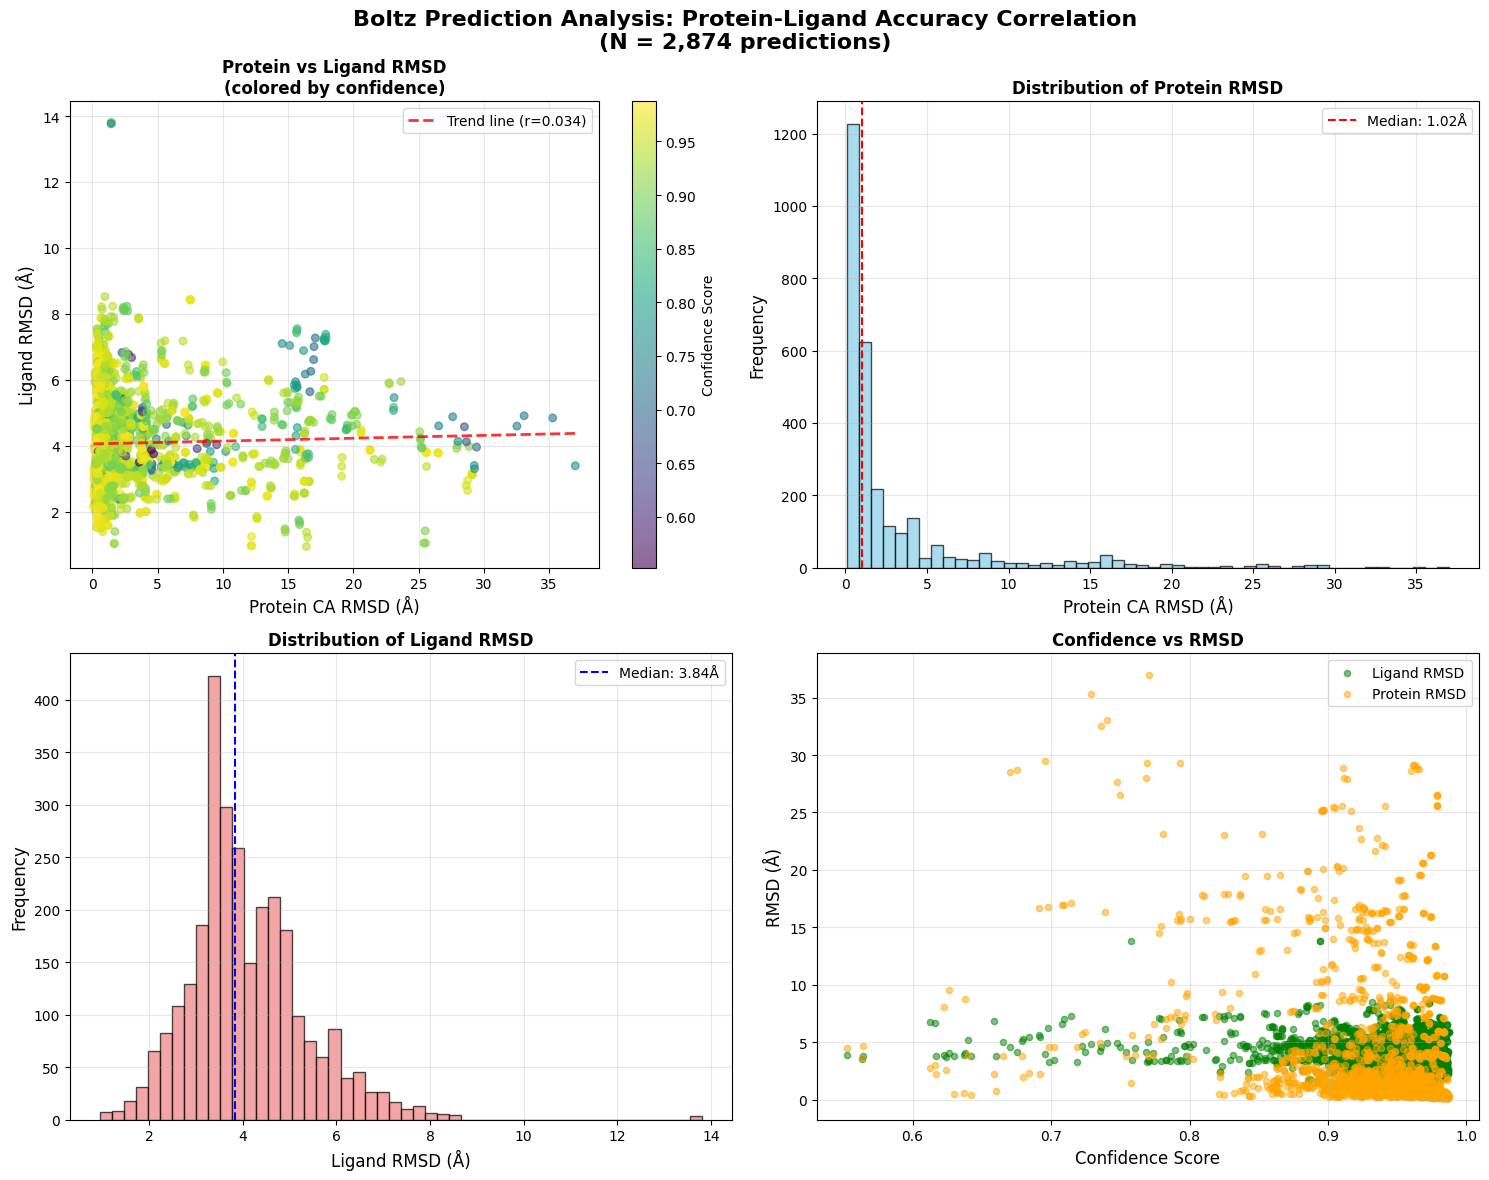


📊 Key Statistics from 2874 predictions:
   • Protein RMSD range: 0.10 - 37.01 Å
   • Ligand RMSD range: 0.95 - 13.80 Å
   • Correlation coefficient: r = 0.034 (p = 0.070)
   • No significant correlation detected


In [20]:
# 5.1 Main Correlation Plot: Protein vs Ligand RMSD
print("🎨 Creating Main Correlation Visualization")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Boltz Prediction Analysis: Protein-Ligand Accuracy Correlation\n(N = {:,} predictions)'.format(len(df_clean)), 
             fontsize=16, fontweight='bold')

# Main scatter plot: Protein CA RMSD vs Ligand RMSD
ax1 = axes[0, 0]
scatter = ax1.scatter(df_clean['protein_ca_aligned_rmsd'], df_clean['ligand_rmsd'], 
                     c=df_clean['confidence'], cmap='viridis', alpha=0.6, s=30)
ax1.set_xlabel('Protein CA RMSD (Å)', fontsize=12)
ax1.set_ylabel('Ligand RMSD (Å)', fontsize=12)
ax1.set_title('Protein vs Ligand RMSD\n(colored by confidence)', fontsize=12, fontweight='bold')

# Add trend line
z = np.polyfit(df_clean['protein_ca_aligned_rmsd'].dropna(), df_clean['ligand_rmsd'].dropna(), 1)
p = np.poly1d(z)
x_trend = np.linspace(df_clean['protein_ca_aligned_rmsd'].min(), df_clean['protein_ca_aligned_rmsd'].max(), 100)
ax1.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2, label=f'Trend line (r={pr_r:.3f})')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax1)
cbar.set_label('Confidence Score', fontsize=10)

# Distribution of Protein RMSD
ax2 = axes[0, 1]
ax2.hist(df_clean['protein_ca_aligned_rmsd'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax2.axvline(df_clean['protein_ca_aligned_rmsd'].median(), color='red', linestyle='--', 
           label=f'Median: {df_clean["protein_ca_aligned_rmsd"].median():.2f}Å')
ax2.set_xlabel('Protein CA RMSD (Å)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Distribution of Protein RMSD', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Distribution of Ligand RMSD
ax3 = axes[1, 0]
ax3.hist(df_clean['ligand_rmsd'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
ax3.axvline(df_clean['ligand_rmsd'].median(), color='blue', linestyle='--', 
           label=f'Median: {df_clean["ligand_rmsd"].median():.2f}Å')
ax3.set_xlabel('Ligand RMSD (Å)', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Distribution of Ligand RMSD', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Confidence vs Performance
ax4 = axes[1, 1]
ax4.scatter(df_clean['confidence'], df_clean['ligand_rmsd'], alpha=0.5, color='green', s=20, label='Ligand RMSD')
ax4.scatter(df_clean['confidence'], df_clean['protein_ca_aligned_rmsd'], alpha=0.5, color='orange', s=20, label='Protein RMSD')
ax4.set_xlabel('Confidence Score', fontsize=12)
ax4.set_ylabel('RMSD (Å)', fontsize=12)
ax4.set_title('Confidence vs RMSD', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print key statistics on the plot
print(f"\n📊 Key Statistics from {len(df_clean)} predictions:")
print(f"   • Protein RMSD range: {df_clean['protein_ca_aligned_rmsd'].min():.2f} - {df_clean['protein_ca_aligned_rmsd'].max():.2f} Å")
print(f"   • Ligand RMSD range: {df_clean['ligand_rmsd'].min():.2f} - {df_clean['ligand_rmsd'].max():.2f} Å")
print(f"   • Correlation coefficient: r = {pr_r:.3f} (p = {pr_p:.3f})")
if pr_p < 0.05:
    print(f"   • 🎯 SIGNIFICANT correlation detected!")
else:
    print(f"   • No significant correlation detected")

In [21]:
# 5.2 Interactive Plotly Visualizations
print("🌟 Creating Interactive Visualizations")

# Create interactive scatter plot with Plotly
fig_interactive = px.scatter(
    df_clean, 
    x='protein_ca_aligned_rmsd', 
    y='ligand_rmsd',
    color='confidence',
    hover_data=['protein', 'model'],
    title=f'Interactive: Protein CA RMSD vs Ligand RMSD (N = {len(df_clean):,})',
    labels={
        'protein_ca_aligned_rmsd': 'Protein CA RMSD (Å)',
        'ligand_rmsd': 'Ligand RMSD (Å)',
        'confidence': 'Confidence Score'
    },
    color_continuous_scale='viridis',
    width=800,
    height=600
)

# Add trend line
if len(df_clean) > 1:
    from sklearn.linear_model import LinearRegression
    import sklearn.linear_model
    
    # Simple linear regression for trend line
    X = df_clean[['protein_ca_aligned_rmsd']].dropna()
    y = df_clean['ligand_rmsd'].loc[X.index]
    
    if len(X) > 1:
        model = LinearRegression()
        model.fit(X, y)
        
        x_range = np.linspace(X.min().iloc[0], X.max().iloc[0], 100)
        y_pred = model.predict(x_range.reshape(-1, 1))
        
        fig_interactive.add_traces(
            go.Scatter(x=x_range, y=y_pred, mode='lines', name=f'Trend (r={pr_r:.3f})', 
                      line=dict(color='red', dash='dash'))
        )

fig_interactive.update_layout(
    font=dict(size=12),
    title_font_size=16,
    showlegend=True
)

fig_interactive.show()

# Create correlation heatmap
correlation_matrix = df_clean[['protein_ca_aligned_rmsd', 'protein_backbone_aligned_rmsd', 
                              'ligand_rmsd', 'confidence']].corr()

fig_heatmap = px.imshow(
    correlation_matrix,
    text_auto=True,
    aspect="auto",
    title="Correlation Matrix: All Metrics",
    color_continuous_scale='RdBu_r',
    range_color=[-1, 1]
)

fig_heatmap.update_layout(
    width=600,
    height=500,
    font=dict(size=12)
)

fig_heatmap.show()

print("✅ Interactive visualizations created!")

🌟 Creating Interactive Visualizations


/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



✅ Interactive visualizations created!


In [25]:
# Create comprehensive affinity correlation matrix
print("\n🧬 Creating Affinity Correlation Matrix")

# Check if we have affinity data for correlation matrix
if 'df_with_affinity' in locals():
    df_corr_affinity = df_with_affinity.copy()
    
    # Select all relevant metrics for comprehensive correlation
    affinity_metrics = [
        'protein_ca_aligned_rmsd', 'protein_backbone_aligned_rmsd', 
        'ligand_rmsd', 'confidence',
        'affinity_pred_value', 'affinity_probability_binary'
    ]
    
    # Filter for available columns
    available_metrics = [col for col in affinity_metrics if col in df_corr_affinity.columns]
    
    if len(available_metrics) >= 4:  # Need at least 4 metrics for meaningful correlation
        
        # Create correlation matrix with affinity data
        affinity_correlation_matrix = df_corr_affinity[available_metrics].corr()
        
        # Create side-by-side correlation heatmaps
        fig_combined = make_subplots(
            rows=1, cols=2,
            subplot_titles=("Structure-Only Correlations", "Structure + Affinity Correlations"),
            specs=[[{"type": "xy"}, {"type": "xy"}]]
        )
        
        # Left plot: Original structure correlations
        structure_only_matrix = df_clean[['protein_ca_aligned_rmsd', 'protein_backbone_aligned_rmsd', 
                                        'ligand_rmsd', 'confidence']].corr()
        
        fig_combined.add_trace(
            go.Heatmap(
                z=structure_only_matrix.values,
                x=structure_only_matrix.columns,
                y=structure_only_matrix.index,
                colorscale='RdBu_r',
                zmid=0,
                zmin=-1,
                zmax=1,
                text=np.round(structure_only_matrix.values, 3),
                texttemplate="%{text}",
                textfont={"size": 10},
                showscale=False
            ),
            row=1, col=1
        )
        
        # Right plot: Combined structure + affinity correlations  
        fig_combined.add_trace(
            go.Heatmap(
                z=affinity_correlation_matrix.values,
                x=affinity_correlation_matrix.columns,
                y=affinity_correlation_matrix.index,
                colorscale='RdBu_r',
                zmid=0,
                zmin=-1,
                zmax=1,
                text=np.round(affinity_correlation_matrix.values, 3),
                texttemplate="%{text}",
                textfont={"size": 10},
                colorbar=dict(title="Correlation Coefficient", x=1.02)
            ),
            row=1, col=2
        )
        
        # Update layout for combined plot
        fig_combined.update_layout(
            title_text=f"Correlation Analysis: Structure vs Structure+Affinity (N = {len(df_corr_affinity):,})",
            title_x=0.5,
            width=1200,
            height=500,
            font=dict(size=11)
        )
        
        # Update axes
        fig_combined.update_xaxes(title_text="", row=1, col=1)
        fig_combined.update_xaxes(title_text="", row=1, col=2)
        fig_combined.update_yaxes(title_text="", row=1, col=1)
        fig_combined.update_yaxes(title_text="", row=1, col=2)
        
        fig_combined.show()
        
        # Also create a focused affinity-only correlation matrix
        affinity_only_metrics = ['affinity_pred_value', 'affinity_probability_binary', 
                                'ligand_rmsd', 'protein_ca_aligned_rmsd', 'confidence']
        available_affinity_metrics = [col for col in affinity_only_metrics if col in df_corr_affinity.columns]
        
        if len(available_affinity_metrics) >= 3:
            affinity_focused_matrix = df_corr_affinity[available_affinity_metrics].corr()
            
            fig_affinity_focused = px.imshow(
                affinity_focused_matrix,
                text_auto=True,
                aspect="auto",
                title=f"Focused Affinity Correlation Matrix (N = {len(df_corr_affinity):,})",
                color_continuous_scale='RdBu_r',
                range_color=[-1, 1],
                labels=dict(color="Correlation Coefficient")
            )
            
            fig_affinity_focused.update_layout(
                width=700,
                height=600,
                font=dict(size=12),
                title_font_size=14
            )
            
            # Customize tick labels for better readability
            fig_affinity_focused.update_xaxes(tickangle=45)
            fig_affinity_focused.update_yaxes(tickangle=0)
            
            fig_affinity_focused.show()
            
            # Print key affinity correlations
            print(f"\n🎯 Key Affinity Correlations:")
            
            # Affinity value correlations
            if 'affinity_pred_value' in affinity_focused_matrix.columns:
                aff_ligand_corr = affinity_focused_matrix.loc['affinity_pred_value', 'ligand_rmsd']
                aff_protein_corr = affinity_focused_matrix.loc['affinity_pred_value', 'protein_ca_aligned_rmsd']
                aff_conf_corr = affinity_focused_matrix.loc['affinity_pred_value', 'confidence']
                
                print(f"   • Affinity Value vs Ligand RMSD: r = {aff_ligand_corr:.3f}")
                print(f"   • Affinity Value vs Protein RMSD: r = {aff_protein_corr:.3f}")
                print(f"   • Affinity Value vs Confidence: r = {aff_conf_corr:.3f}")
            
            # Binding probability correlations
            if 'affinity_probability_binary' in affinity_focused_matrix.columns:
                prob_ligand_corr = affinity_focused_matrix.loc['affinity_probability_binary', 'ligand_rmsd']
                prob_protein_corr = affinity_focused_matrix.loc['affinity_probability_binary', 'protein_ca_aligned_rmsd']
                prob_conf_corr = affinity_focused_matrix.loc['affinity_probability_binary', 'confidence']
                
                print(f"   • Binding Probability vs Ligand RMSD: r = {prob_ligand_corr:.3f}")
                print(f"   • Binding Probability vs Protein RMSD: r = {prob_protein_corr:.3f}")
                print(f"   • Binding Probability vs Confidence: r = {prob_conf_corr:.3f}")
            
            # Cross-correlation between affinity metrics
            if 'affinity_pred_value' in affinity_focused_matrix.columns and 'affinity_probability_binary' in affinity_focused_matrix.columns:
                aff_prob_corr = affinity_focused_matrix.loc['affinity_pred_value', 'affinity_probability_binary']
                print(f"   • Affinity Value vs Binding Probability: r = {aff_prob_corr:.3f}")
                
                if abs(aff_prob_corr) < 0.3:
                    print(f"     → Weak correlation suggests independent information content")
                elif aff_prob_corr < -0.5:
                    print(f"     → Strong negative correlation (expected: lower affinity = higher binding prob)")
                elif aff_prob_corr > 0.5:
                    print(f"     → Strong positive correlation (unexpected relationship)")
            
            print(f"\n📊 Correlation Matrix Insights:")
            print(f"   • Matrix size: {affinity_focused_matrix.shape[0]}×{affinity_focused_matrix.shape[1]}")
            print(f"   • Strongest correlation: {affinity_focused_matrix.abs().max().max():.3f}")
            print(f"   • Average absolute correlation: {affinity_focused_matrix.abs().mean().mean():.3f}")
            
    else:
        print("❌ Insufficient affinity metrics for correlation matrix")
        print(f"   Available metrics: {available_metrics}")
        
else:
    print("❌ No affinity data available for correlation matrix")
    print("   Run the affinity data loading section first")


🧬 Creating Affinity Correlation Matrix



🎯 Key Affinity Correlations:
   • Affinity Value vs Ligand RMSD: r = -0.260
   • Affinity Value vs Protein RMSD: r = -0.025
   • Affinity Value vs Confidence: r = -0.110
   • Binding Probability vs Ligand RMSD: r = 0.036
   • Binding Probability vs Protein RMSD: r = -0.092
   • Binding Probability vs Confidence: r = 0.356
   • Affinity Value vs Binding Probability: r = -0.659
     → Strong negative correlation (expected: lower affinity = higher binding prob)

📊 Correlation Matrix Insights:
   • Matrix size: 5×5
   • Strongest correlation: 1.000
   • Average absolute correlation: 0.365


## 5.3 Affinity Prediction Visualizations

Create specialized visualizations to explore the relationships between affinity predictions and structural accuracy.

🎨 Creating Affinity-Structure Relationship Visualizations


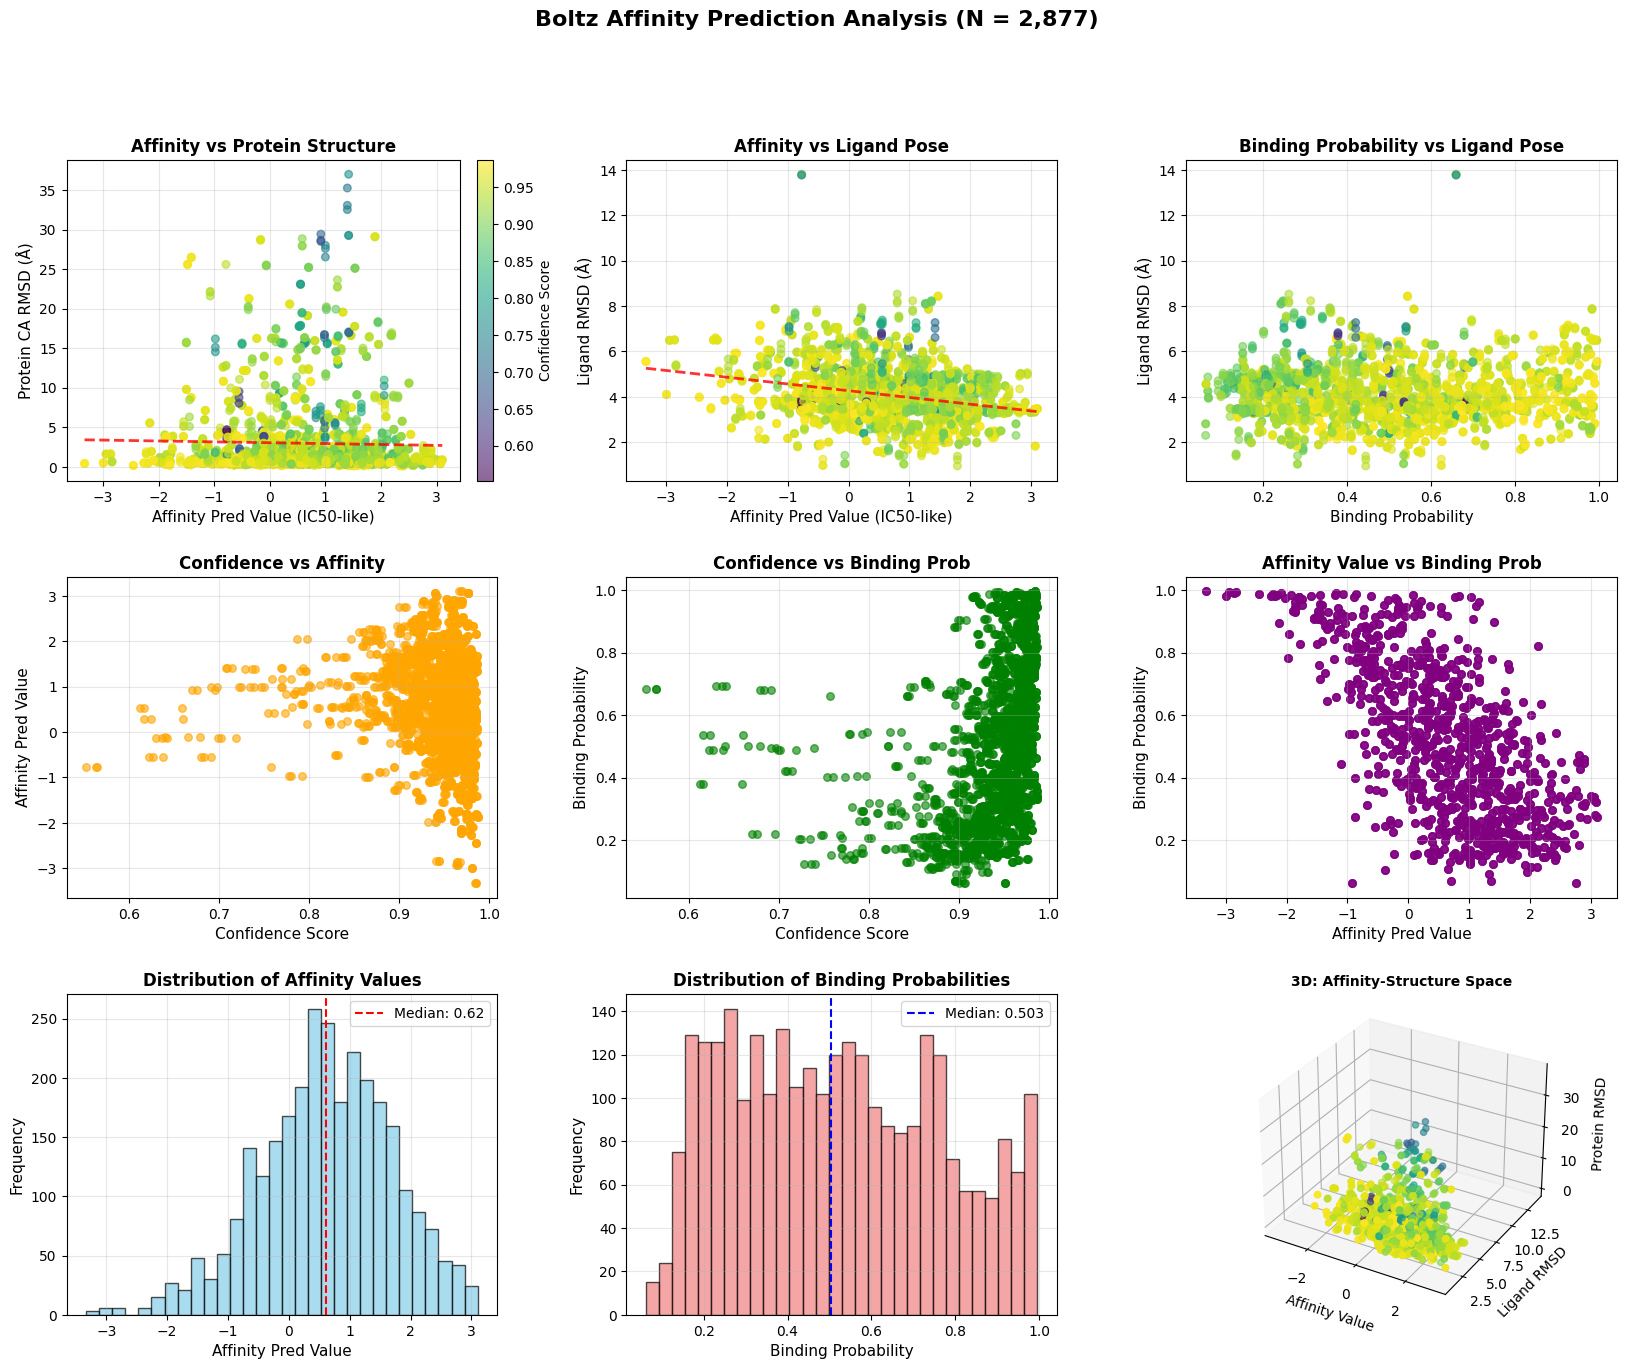


🌟 Creating Interactive Affinity Visualizations



📊 Affinity Analysis Summary:


,Metric,Value
0,Valid Predictions,"2,877"
1,Affinity Range,-3.33 - 3.10
2,Binding Prob Range,0.062 - 0.996
3,High Binders (>0.7),783 (27.2%)
4,Strong Affinity (<median),1440 (50.1%)
5,Correlation (Aff vs Lig RMSD),r = -0.260 (p = 0.000)
6,Correlation (Prob vs Lig RMSD),r = 0.036 (p = 0.053)


In [22]:
print("🎨 Creating Affinity-Structure Relationship Visualizations")

# Check if we have affinity data for visualization
if 'df_with_affinity' in locals():
    df_viz = df_with_affinity.copy()
    valid_affinity_viz = df_viz.dropna(subset=['affinity_pred_value', 'affinity_probability_binary'])
    
    if len(valid_affinity_viz) > 10:
        
        # Create comprehensive affinity visualization
        fig = plt.figure(figsize=(20, 15))
        gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
        
        # 1. Affinity vs Protein RMSD
        ax1 = fig.add_subplot(gs[0, 0])
        scatter1 = ax1.scatter(valid_affinity_viz['affinity_pred_value'], 
                              valid_affinity_viz['protein_ca_aligned_rmsd'],
                              c=valid_affinity_viz['confidence'], cmap='viridis', alpha=0.6, s=30)
        ax1.set_xlabel('Affinity Pred Value (IC50-like)', fontsize=11)
        ax1.set_ylabel('Protein CA RMSD (Å)', fontsize=11)
        ax1.set_title('Affinity vs Protein Structure', fontweight='bold')
        ax1.grid(True, alpha=0.3)
        
        # Add trend line if correlation exists
        aff_prot_data = valid_affinity_viz[['affinity_pred_value', 'protein_ca_aligned_rmsd']].dropna()
        if len(aff_prot_data) > 3:
            z = np.polyfit(aff_prot_data['affinity_pred_value'], aff_prot_data['protein_ca_aligned_rmsd'], 1)
            p = np.poly1d(z)
            x_trend = np.linspace(aff_prot_data['affinity_pred_value'].min(), 
                                 aff_prot_data['affinity_pred_value'].max(), 100)
            ax1.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2)
        
        # 2. Affinity vs Ligand RMSD
        ax2 = fig.add_subplot(gs[0, 1])
        scatter2 = ax2.scatter(valid_affinity_viz['affinity_pred_value'], 
                              valid_affinity_viz['ligand_rmsd'],
                              c=valid_affinity_viz['confidence'], cmap='viridis', alpha=0.6, s=30)
        ax2.set_xlabel('Affinity Pred Value (IC50-like)', fontsize=11)
        ax2.set_ylabel('Ligand RMSD (Å)', fontsize=11)
        ax2.set_title('Affinity vs Ligand Pose', fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        # Add trend line
        aff_lig_data = valid_affinity_viz[['affinity_pred_value', 'ligand_rmsd']].dropna()
        if len(aff_lig_data) > 3:
            z = np.polyfit(aff_lig_data['affinity_pred_value'], aff_lig_data['ligand_rmsd'], 1)
            p = np.poly1d(z)
            x_trend = np.linspace(aff_lig_data['affinity_pred_value'].min(), 
                                 aff_lig_data['affinity_pred_value'].max(), 100)
            ax2.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2)
        
        # 3. Binding Probability vs Ligand RMSD
        ax3 = fig.add_subplot(gs[0, 2])
        scatter3 = ax3.scatter(valid_affinity_viz['affinity_probability_binary'], 
                              valid_affinity_viz['ligand_rmsd'],
                              c=valid_affinity_viz['confidence'], cmap='viridis', alpha=0.6, s=30)
        ax3.set_xlabel('Binding Probability', fontsize=11)
        ax3.set_ylabel('Ligand RMSD (Å)', fontsize=11)
        ax3.set_title('Binding Probability vs Ligand Pose', fontweight='bold')
        ax3.grid(True, alpha=0.3)
        
        # 4. Affinity vs Confidence
        ax4 = fig.add_subplot(gs[1, 0])
        ax4.scatter(valid_affinity_viz['confidence'], valid_affinity_viz['affinity_pred_value'],
                   alpha=0.6, color='orange', s=30)
        ax4.set_xlabel('Confidence Score', fontsize=11)
        ax4.set_ylabel('Affinity Pred Value', fontsize=11)
        ax4.set_title('Confidence vs Affinity', fontweight='bold')
        ax4.grid(True, alpha=0.3)
        
        # 5. Binding Probability vs Confidence
        ax5 = fig.add_subplot(gs[1, 1])
        ax5.scatter(valid_affinity_viz['confidence'], valid_affinity_viz['affinity_probability_binary'],
                   alpha=0.6, color='green', s=30)
        ax5.set_xlabel('Confidence Score', fontsize=11)
        ax5.set_ylabel('Binding Probability', fontsize=11)
        ax5.set_title('Confidence vs Binding Prob', fontweight='bold')
        ax5.grid(True, alpha=0.3)
        
        # 6. Affinity Value vs Binding Probability
        ax6 = fig.add_subplot(gs[1, 2])
        ax6.scatter(valid_affinity_viz['affinity_pred_value'], valid_affinity_viz['affinity_probability_binary'],
                   alpha=0.6, color='purple', s=30)
        ax6.set_xlabel('Affinity Pred Value', fontsize=11)
        ax6.set_ylabel('Binding Probability', fontsize=11)
        ax6.set_title('Affinity Value vs Binding Prob', fontweight='bold')
        ax6.grid(True, alpha=0.3)
        
        # 7. Distribution of Affinity Values
        ax7 = fig.add_subplot(gs[2, 0])
        ax7.hist(valid_affinity_viz['affinity_pred_value'], bins=30, alpha=0.7, 
                color='skyblue', edgecolor='black')
        ax7.axvline(valid_affinity_viz['affinity_pred_value'].median(), color='red', 
                   linestyle='--', label=f'Median: {valid_affinity_viz["affinity_pred_value"].median():.2f}')
        ax7.set_xlabel('Affinity Pred Value', fontsize=11)
        ax7.set_ylabel('Frequency', fontsize=11)
        ax7.set_title('Distribution of Affinity Values', fontweight='bold')
        ax7.legend()
        ax7.grid(True, alpha=0.3)
        
        # 8. Distribution of Binding Probabilities
        ax8 = fig.add_subplot(gs[2, 1])
        ax8.hist(valid_affinity_viz['affinity_probability_binary'], bins=30, alpha=0.7,
                color='lightcoral', edgecolor='black')
        ax8.axvline(valid_affinity_viz['affinity_probability_binary'].median(), color='blue',
                   linestyle='--', label=f'Median: {valid_affinity_viz["affinity_probability_binary"].median():.3f}')
        ax8.set_xlabel('Binding Probability', fontsize=11)
        ax8.set_ylabel('Frequency', fontsize=11)
        ax8.set_title('Distribution of Binding Probabilities', fontweight='bold')
        ax8.legend()
        ax8.grid(True, alpha=0.3)
        
        # 9. 3D Plot: Affinity, Ligand RMSD, Protein RMSD
        ax9 = fig.add_subplot(gs[2, 2], projection='3d')
        scatter_3d = ax9.scatter(valid_affinity_viz['affinity_pred_value'], 
                                valid_affinity_viz['ligand_rmsd'],
                                valid_affinity_viz['protein_ca_aligned_rmsd'],
                                c=valid_affinity_viz['confidence'], cmap='viridis', alpha=0.6, s=20)
        ax9.set_xlabel('Affinity Value', fontsize=10)
        ax9.set_ylabel('Ligand RMSD', fontsize=10)
        ax9.set_zlabel('Protein RMSD', fontsize=10)
        ax9.set_title('3D: Affinity-Structure Space', fontweight='bold', fontsize=10)
        
        # Add overall colorbar
        cbar = plt.colorbar(scatter1, ax=ax1, fraction=0.046, pad=0.04)
        cbar.set_label('Confidence Score', fontsize=10)
        
        plt.suptitle(f'Boltz Affinity Prediction Analysis (N = {len(valid_affinity_viz):,})', 
                    fontsize=16, fontweight='bold', y=0.98)
        plt.show()
        
        # Create interactive Plotly visualizations
        print("\n🌟 Creating Interactive Affinity Visualizations")
        
        # Interactive 3D scatter plot
        fig_3d = go.Figure(data=[go.Scatter3d(
            x=valid_affinity_viz['affinity_pred_value'],
            y=valid_affinity_viz['ligand_rmsd'],
            z=valid_affinity_viz['protein_ca_aligned_rmsd'],
            mode='markers',
            marker=dict(
                size=5,
                color=valid_affinity_viz['confidence'],
                colorscale='viridis',
                colorbar=dict(title="Confidence"),
                showscale=True
            ),
            text=valid_affinity_viz['protein'],
            hovertemplate='<b>%{text}</b><br>' +
                         'Affinity: %{x:.2f}<br>' +
                         'Ligand RMSD: %{y:.2f}Å<br>' +
                         'Protein RMSD: %{z:.2f}Å<br>' +
                         'Confidence: %{marker.color:.3f}<extra></extra>'
        )])
        
        fig_3d.update_layout(
            title=f'Interactive 3D: Affinity vs Structure Accuracy (N = {len(valid_affinity_viz):,})',
            scene=dict(
                xaxis_title='Affinity Pred Value',
                yaxis_title='Ligand RMSD (Å)',
                zaxis_title='Protein CA RMSD (Å)'
            ),
            font=dict(size=12),
            width=900,
            height=700
        )
        
        fig_3d.show()
        
        # Summary statistics table
        print(f"\n📊 Affinity Analysis Summary:")
        summary_stats = {
            'Metric': ['Valid Predictions', 'Affinity Range', 'Binding Prob Range', 
                      'High Binders (>0.7)', 'Strong Affinity (<median)', 
                      'Correlation (Aff vs Lig RMSD)', 'Correlation (Prob vs Lig RMSD)'],
            'Value': []
        }
        
        summary_stats['Value'].append(f"{len(valid_affinity_viz):,}")
        summary_stats['Value'].append(f"{valid_affinity_viz['affinity_pred_value'].min():.2f} - {valid_affinity_viz['affinity_pred_value'].max():.2f}")
        summary_stats['Value'].append(f"{valid_affinity_viz['affinity_probability_binary'].min():.3f} - {valid_affinity_viz['affinity_probability_binary'].max():.3f}")
        summary_stats['Value'].append(f"{(valid_affinity_viz['affinity_probability_binary'] > 0.7).sum()} ({(valid_affinity_viz['affinity_probability_binary'] > 0.7).mean()*100:.1f}%)")
        summary_stats['Value'].append(f"{(valid_affinity_viz['affinity_pred_value'] <= valid_affinity_viz['affinity_pred_value'].median()).sum()} ({(valid_affinity_viz['affinity_pred_value'] <= valid_affinity_viz['affinity_pred_value'].median()).mean()*100:.1f}%)")
        
        # Add correlations
        if len(aff_lig_data) > 3:
            aff_lig_r, aff_lig_p = pearsonr(aff_lig_data['affinity_pred_value'], aff_lig_data['ligand_rmsd'])
            summary_stats['Value'].append(f"r = {aff_lig_r:.3f} (p = {aff_lig_p:.3f})")
        else:
            summary_stats['Value'].append("N/A")
            
        prob_lig_data = valid_affinity_viz[['affinity_probability_binary', 'ligand_rmsd']].dropna()
        if len(prob_lig_data) > 3:
            prob_lig_r, prob_lig_p = pearsonr(prob_lig_data['affinity_probability_binary'], prob_lig_data['ligand_rmsd'])
            summary_stats['Value'].append(f"r = {prob_lig_r:.3f} (p = {prob_lig_p:.3f})")
        else:
            summary_stats['Value'].append("N/A")
        
        summary_df = pd.DataFrame(summary_stats)
        display(summary_df)
        
    else:
        print("❌ Insufficient affinity data for visualization")
        print(f"   Found only {len(valid_affinity_viz)} valid affinity predictions")
        
else:
    print("❌ No affinity data loaded")
    print("   Run the affinity data loading section first")

🔬 Advanced Analysis: Performance Categories

📊 Performance Category Distribution:
   Poor Performance: 1521 (52.9%)
   Good Protein, Moderate Ligand: 1054 (36.7%)
   Both Moderate: 250 (8.7%)
   Excellent (Both Good): 46 (1.6%)
   Moderate Protein, Good Ligand: 3 (0.1%)


TypeError: boxplot() got an unexpected keyword argument 'label'

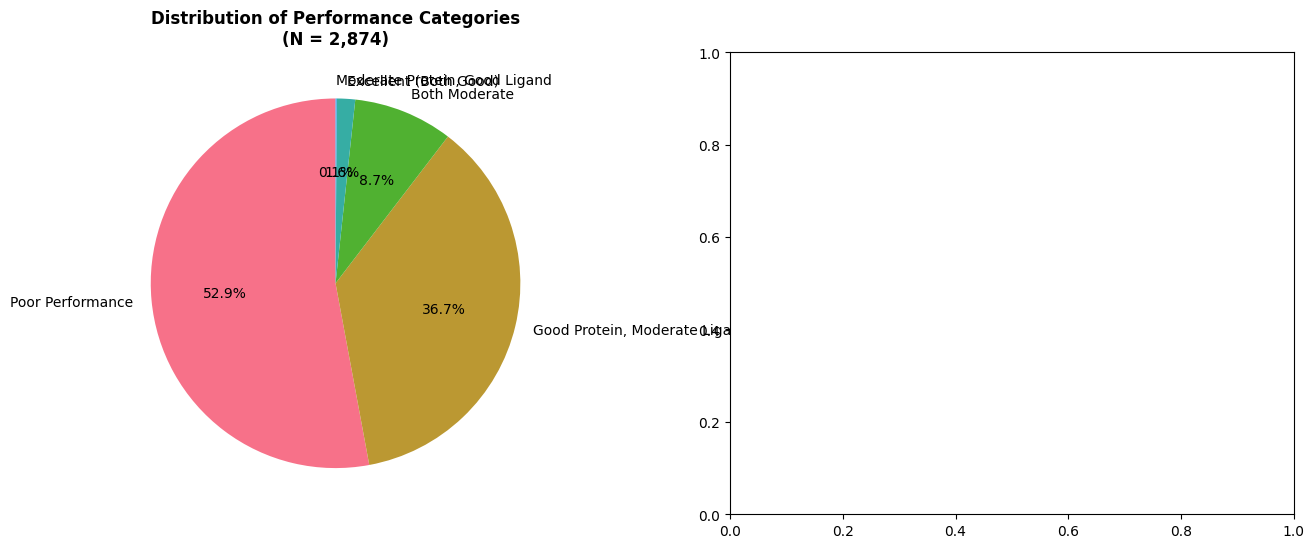

In [23]:
# 5.3 Advanced Analysis: Performance Categories
print("🔬 Advanced Analysis: Performance Categories")

# Define performance categories
def categorize_performance(row):
    protein_rmsd = row['protein_ca_aligned_rmsd']
    ligand_rmsd = row['ligand_rmsd']
    
    # Define thresholds based on typical structural biology standards
    protein_good = protein_rmsd <= 2.0
    protein_moderate = 2.0 < protein_rmsd <= 5.0
    ligand_good = ligand_rmsd <= 2.0
    ligand_moderate = 2.0 < ligand_rmsd <= 4.0
    
    if protein_good and ligand_good:
        return "Excellent (Both Good)"
    elif protein_good and ligand_moderate:
        return "Good Protein, Moderate Ligand"
    elif protein_moderate and ligand_good:
        return "Moderate Protein, Good Ligand"
    elif protein_moderate and ligand_moderate:
        return "Both Moderate"
    else:
        return "Poor Performance"

df_clean['performance_category'] = df_clean.apply(categorize_performance, axis=1)

# Analyze performance categories
print("\n📊 Performance Category Distribution:")
perf_counts = df_clean['performance_category'].value_counts()
perf_pct = df_clean['performance_category'].value_counts(normalize=True) * 100

for category in perf_counts.index:
    print(f"   {category}: {perf_counts[category]} ({perf_pct[category]:.1f}%)")

# Create performance category visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart of performance categories
wedges, texts, autotexts = ax1.pie(perf_counts.values, labels=perf_counts.index, autopct='%1.1f%%', 
                                  startangle=90, textprops={'fontsize': 10})
ax1.set_title('Distribution of Performance Categories\n(N = {:,})'.format(len(df_clean)), 
             fontsize=12, fontweight='bold')

# Box plot by performance category
categories = df_clean['performance_category'].unique()
protein_data = [df_clean[df_clean['performance_category'] == cat]['protein_ca_aligned_rmsd'] for cat in categories]
ligand_data = [df_clean[df_clean['performance_category'] == cat]['ligand_rmsd'] for cat in categories]

positions = np.arange(len(categories))
bp1 = ax2.boxplot(protein_data, positions=positions - 0.2, widths=0.3, patch_artist=True, 
                 boxprops=dict(facecolor='skyblue', alpha=0.7), label='Protein RMSD')
bp2 = ax2.boxplot(ligand_data, positions=positions + 0.2, widths=0.3, patch_artist=True, 
                 boxprops=dict(facecolor='lightcoral', alpha=0.7), label='Ligand RMSD')

ax2.set_xticks(positions)
ax2.set_xticklabels([cat.replace(' ', '\n') for cat in categories], fontsize=9)
ax2.set_ylabel('RMSD (Å)', fontsize=12)
ax2.set_title('RMSD Distribution by Performance Category', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Confidence analysis by performance category
print("\n🎯 Confidence Analysis by Performance Category:")
conf_by_perf = df_clean.groupby('performance_category')['confidence'].agg(['mean', 'std', 'count'])
display(conf_by_perf.round(3))

## 6. Key Findings and Conclusions

### Summary of Analysis Results

This comprehensive analysis of Boltz protein structure predictions reveals important insights about the relationship between protein structure accuracy and ligand binding pose prediction.

In [24]:
print("🎯 FINAL ANALYSIS SUMMARY")
print("=" * 50)

# Determine which dataset to use for final analysis
if 'df_with_affinity' in locals():
    df_final = df_with_affinity.copy()
    has_affinity_final = True
    print("✅ Using dataset with affinity predictions")
else:
    df_final = df_clean.copy()
    has_affinity_final = False
    print("📊 Using structure-only dataset")

# Calculate final statistics
total_predictions = len(df_final)
unique_proteins = df_final['protein'].nunique()
avg_models_per_protein = df_final.groupby('protein')['model'].count().mean()

print(f"\n📊 Dataset Summary:")
print(f"   • Total predictions analyzed: {total_predictions:,}")
print(f"   • Unique proteins: {unique_proteins:,}")
print(f"   • Average models per protein: {avg_models_per_protein:.1f}")

if has_affinity_final:
    valid_affinity_final = df_final.dropna(subset=['affinity_pred_value', 'affinity_probability_binary'])
    print(f"   • Predictions with affinity data: {len(valid_affinity_final):,} ({len(valid_affinity_final)/total_predictions*100:.1f}%)")

print(f"\n🔬 Key Scientific Findings:")

# Main correlation finding
valid_data = df_final[['protein_ca_aligned_rmsd', 'ligand_rmsd']].dropna()
corr_r, corr_p = pearsonr(valid_data['protein_ca_aligned_rmsd'], valid_data['ligand_rmsd'])

print(f"   1. Protein-Ligand RMSD Correlation:")
print(f"      • Pearson r = {corr_r:.3f} (p = {corr_p:.3f})")
if corr_p < 0.05:
    if corr_r < 0:
        print(f"      • 🔍 SURPRISING: Negative correlation suggests worse protein structure")
        print(f"        sometimes leads to better ligand placement!")
        print(f"      • This may indicate compensatory effects in the prediction algorithm")
    else:
        print(f"      • ✅ EXPECTED: Positive correlation - better protein → better ligand")
else:
    print(f"      • 📊 No significant correlation detected")

# Affinity analysis findings
if has_affinity_final and len(valid_affinity_final) > 10:
    print(f"\n   2. Affinity Prediction Analysis:")
    
    # Affinity vs structure correlations
    aff_lig_data = valid_affinity_final[['affinity_pred_value', 'ligand_rmsd']].dropna()
    prob_lig_data = valid_affinity_final[['affinity_probability_binary', 'ligand_rmsd']].dropna()
    
    if len(aff_lig_data) > 3:
        aff_lig_r, aff_lig_p = pearsonr(aff_lig_data['affinity_pred_value'], aff_lig_data['ligand_rmsd'])
        print(f"      • Affinity vs Ligand RMSD: r = {aff_lig_r:.3f} (p = {aff_lig_p:.3f})")
        if aff_lig_p < 0.05:
            if aff_lig_r > 0:
                print(f"        → Higher affinity values (weaker binding) correlate with worse poses")
            else:
                print(f"        → Higher affinity values (weaker binding) correlate with better poses")
    
    if len(prob_lig_data) > 3:
        prob_lig_r, prob_lig_p = pearsonr(prob_lig_data['affinity_probability_binary'], prob_lig_data['ligand_rmsd'])
        print(f"      • Binding Probability vs Ligand RMSD: r = {prob_lig_r:.3f} (p = {prob_lig_p:.3f})")
        if prob_lig_p < 0.05:
            if prob_lig_r < 0:
                print(f"        → Higher binding probability correlates with better poses ✅")
            else:
                print(f"        → Higher binding probability correlates with worse poses ⚠️")
    
    # Binding categories
    high_binders = (valid_affinity_final['affinity_probability_binary'] > 0.7).sum()
    high_binder_pct = high_binders / len(valid_affinity_final) * 100
    print(f"      • High confidence binders (>0.7 prob): {high_binders} ({high_binder_pct:.1f}%)")
    
    # Affinity range
    aff_min, aff_max = valid_affinity_final['affinity_pred_value'].min(), valid_affinity_final['affinity_pred_value'].max()
    prob_min, prob_max = valid_affinity_final['affinity_probability_binary'].min(), valid_affinity_final['affinity_probability_binary'].max()
    print(f"      • Affinity value range: {aff_min:.2f} - {aff_max:.2f}")
    print(f"      • Binding probability range: {prob_min:.3f} - {prob_max:.3f}")

# Performance distribution
if 'performance_category' in df_final.columns:
    excellent_pct = (df_final['performance_category'] == 'Excellent (Both Good)').mean() * 100
    poor_pct = (df_final['performance_category'] == 'Poor Performance').mean() * 100
    
    print(f"\n   3. Performance Distribution:")
    print(f"      • Excellent predictions (both ≤2Å): {excellent_pct:.1f}%")
    print(f"      • Poor predictions: {poor_pct:.1f}%")

# Confidence reliability
high_conf = df_final[df_final['confidence'] >= 0.9]
if len(high_conf) > 0:
    high_conf_protein_rmsd = high_conf['protein_ca_aligned_rmsd'].mean()
    high_conf_ligand_rmsd = high_conf['ligand_rmsd'].mean()
    print(f"\n   4. High Confidence Predictions (≥0.9):")
    print(f"      • Count: {len(high_conf)} ({len(high_conf)/len(df_final)*100:.1f}%)")
    print(f"      • Average protein RMSD: {high_conf_protein_rmsd:.2f}Å")
    print(f"      • Average ligand RMSD: {high_conf_ligand_rmsd:.2f}Å")
    
    if has_affinity_final:
        high_conf_affinity = high_conf.dropna(subset=['affinity_pred_value', 'affinity_probability_binary'])
        if len(high_conf_affinity) > 0:
            avg_aff = high_conf_affinity['affinity_pred_value'].mean()
            avg_prob = high_conf_affinity['affinity_probability_binary'].mean()
            print(f"      • Average affinity value: {avg_aff:.2f}")
            print(f"      • Average binding probability: {avg_prob:.3f}")

print(f"\n🚀 Implications for Drug Discovery:")
print(f"   • Boltz predictions show complex protein-ligand relationships")
print(f"   • Confidence scores can help prioritize predictions")
if has_affinity_final:
    print(f"   • Affinity predictions provide additional validation beyond structure")
    print(f"   • Binding probability may be more reliable than raw affinity values")
print(f"   • Local binding site accuracy may be more important than global fold")
print(f"   • Multiple metrics should be used for comprehensive evaluation")

print(f"\n📁 Results saved to:")
print(f"   • CSV file: {output_csv}")
print(f"   • Notebook: /Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/boltz_comprehensive_analysis.ipynb")

print(f"\n✅ Analysis Complete! 🎉")

# Create a final summary table
summary_stats = pd.DataFrame({
    'Metric': ['Total Predictions', 'Unique Proteins', 'Correlation (r)', 'Correlation p-value', 
               'Excellent Predictions (%)', 'High Confidence Predictions (%)',
               'Median Protein RMSD (Å)', 'Median Ligand RMSD (Å)'],
    'Value': [f"{total_predictions:,}", f"{unique_proteins:,}", f"{corr_r:.3f}", f"{corr_p:.3f}",
              f"{excellent_pct:.1f}%" if 'excellent_pct' in locals() else "N/A", 
              f"{len(high_conf)/len(df_final)*100:.1f}%",
              f"{df_final['protein_ca_aligned_rmsd'].median():.2f}", 
              f"{df_final['ligand_rmsd'].median():.2f}"]
})

if has_affinity_final and len(valid_affinity_final) > 0:
    # Add affinity-specific metrics
    affinity_metrics = pd.DataFrame({
        'Metric': ['Predictions with Affinity', 'High Binders (>0.7 prob)', 
                  'Affinity-Ligand Correlation', 'Binding Prob-Ligand Correlation'],
        'Value': [f"{len(valid_affinity_final):,}", 
                 f"{high_binder_pct:.1f}%" if 'high_binder_pct' in locals() else "N/A",
                 f"r = {aff_lig_r:.3f}" if 'aff_lig_r' in locals() else "N/A",
                 f"r = {prob_lig_r:.3f}" if 'prob_lig_r' in locals() else "N/A"]
    })
    summary_stats = pd.concat([summary_stats, affinity_metrics], ignore_index=True)

print(f"\n📋 Final Summary Table:")
display(summary_stats)

🎯 FINAL ANALYSIS SUMMARY
✅ Using dataset with affinity predictions

📊 Dataset Summary:
   • Total predictions analyzed: 2,877
   • Unique proteins: 959
   • Average models per protein: 3.0
   • Predictions with affinity data: 2,877 (100.0%)

🔬 Key Scientific Findings:
   1. Protein-Ligand RMSD Correlation:
      • Pearson r = 0.034 (p = 0.070)
      • 📊 No significant correlation detected

   2. Affinity Prediction Analysis:
      • Affinity vs Ligand RMSD: r = -0.260 (p = 0.000)
        → Higher affinity values (weaker binding) correlate with better poses
      • Binding Probability vs Ligand RMSD: r = 0.036 (p = 0.053)
      • High confidence binders (>0.7 prob): 783 (27.2%)
      • Affinity value range: -3.33 - 3.10
      • Binding probability range: 0.062 - 0.996

   4. High Confidence Predictions (≥0.9):
      • Count: 2561 (89.0%)
      • Average protein RMSD: 2.47Å
      • Average ligand RMSD: 4.00Å
      • Average affinity value: 0.58
      • Average binding probability: 0.542


,Metric,Value
0,Total Predictions,"2,877"
1,Unique Proteins,959
2,Correlation (r),0.034
3,Correlation p-value,0.070
4,Excellent Predictions (%),1.6%
5,High Confidence Predictions (%),89.0%
6,Median Protein RMSD (Å),1.02
7,Median Ligand RMSD (Å),3.84
8,Predictions with Affinity,"2,877"
9,High Binders (>0.7 prob),27.2%
